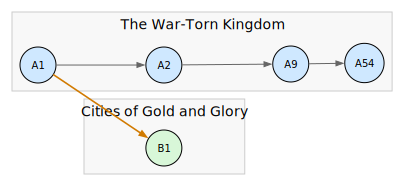

Saved as: fabled_lands_map.pdf


In [13]:
# !pip install graphviz

import os
import glob
import pandas as pd
from graphviz import Digraph
from IPython.display import SVG, display

data_path = "Data"

book_names_map = {
    "A": "The War-Torn Kingdom",
    "B": "Cities of Gold and Glory",
    "C": "Over the Blood-Dark Sea",
    "D": "The Plains of Howling Darkness",
    "E": "The Court of Hidden Faces",
    "F": "Lords of the Rising Sun",
    "G": "The Serpent King's Domain",
}

edges = []

for filepath in glob.glob(os.path.join(data_path, "*.csv")):
    df = pd.read_csv(filepath)
    cols_lower = {c.lower(): c for c in df.columns}
    s_col = cols_lower["source"]
    t_col = cols_lower["target"]

    for a, b in zip(df[s_col], df[t_col]):
        if pd.isna(a) or pd.isna(b):
            continue
        edges.append((str(a).strip().lower(), str(b).strip().lower()))

nodes = {u for e in edges for u in e}

books = sorted({n[0] for n in nodes})

palette = ["#cfe8ff", "#d8f7d8", "#ffe8cf", "#f8d6f7", "#f7f7a8", "#e0cfe8", "#f7bcbc"]
book_fill = {b: palette[i % len(palette)] for i, b in enumerate(books)}
cross_edge_color = "#d17a00"

g = Digraph("fabled_lands", format="svg")
g.attr(rankdir="LR", splines="true", overlap="false", fontname="Inter")
g.attr("node", shape="circle", style="filled", fontname="Inter", fontsize="10")
g.attr("edge", arrowsize="0.7", color="#666666")

clusters = {}
for b in books:
    clusters[b] = Digraph(name=f"cluster_{b.upper()}")
    nice_label = book_names_map.get(b.upper(), f"Book {b.upper()}")
    clusters[b].attr(label=nice_label, style="filled", color="#cccccc", fillcolor="#f8f8f8")

def sortkey(n):
    try:
        return (n[0], int(n[1:]))
    except:
        return (n[0], n[1:])

for n in sorted(nodes, key=sortkey):
    b = n[0]
    clusters[b].node(n, label=n.upper(), fillcolor=book_fill[b])

for c in clusters.values():
    g.subgraph(c)

for u, v in edges:
    if u[0] != v[0]:
        g.edge(u, v, color=cross_edge_color, penwidth="1.6")
    else:
        g.edge(u, v)

svg_data = g.pipe(format="svg").decode("utf-8")
display(SVG(svg_data))

pdf_path = g.render(filename="fabled_lands_map", format="pdf", cleanup = True)
print("Saved as:", pdf_path)
